# **Information Theory**

*Authors: Ignacio Cordova Pou and Daniel Beteta Francisco*

## **0. Introduction and objectives**

Central Pattern generators (CPGs) are neural circuits that produce signals to drive rhythmic behaviors like walking, breathing, or chewing. In this project we calculate the Mutual Information (MI) between the time series of the VD and de LP neurons of the CPG circuit of a crab. The neural signals will be analyzed in three different states: control (TrozoC), Gaba injection (TrozoG) and system recovery (TrozoR). To measure the information exchange between CPG neurons we use Shannon’s [1] concept of mutual information. 

We start from the premise that the information carrying events are the "action potentials" in neurons, also known as "nerve impulses" or "spikes". We also assume that all the information is completely contained in the temporal evolution of this membrane potential. 

### Signal and Coding Space for Information Measure

For this project we discretize the signal and perform a mapping to binary [2]. In order to discretize the temporal evolution of the membrane potential we divide our time space in $N$ time windows of size $∆t$ and assign a value of 1 to each bin ∆t where a spike is present. Those bins where no spike is present are assigned a value of 0. For this project we use bins of sizes $bin\_size = [1,\sim 130] \ (0.1ms)$ in order to avoid lossing spikes in the discretization process. We now have a discrete temporal sequence $\{e_t \ ; t = 1...N\}$ where $e_t$ can be 0 or 1. We define a word wtL of size L at time t as a sequence of symbols $w_t^L = \{e_t, e_{t+1} . . . , e_{t+L}\}$. Thus, there are $N-L-1$ words of L bits in each time series when using a sliding window. When using a non-sliding window, there are $\frac{N}{L}$ words of L bits in each time series.  In this project we will analyze the transmission of information between nerons using words of size $L = \{1,2,3,4,5,6,7,8\}$. 

### Mutual information MI

The mutual information between the two neurons given the discretized space of $N-L-1$ words (or $\frac{N}{L}$ when using a non-slinding window) is calculated using the probabiliy of each event (word) $P(lp)$ and $P(vd)$ and the joint probability of the two signals $P(lp,vd)$ being $lp\in LP$ and $vd\in VD$ the words present in the discretized time series $LP$ and $VD$ neurons respectively.  

$$
MI(LP,VD) = \ \sum_{lp\in LP} \sum_{vd\in VD} P(lp,vd) \ log_2 \frac{P(lp,vd)}{P(lp)P(vd)} \ge 0
$$

Note that when representing MI we divide by the window size $\Delta t$ and by the word size L. 

### Normalized average mutual information $E$
To obtain a normalized and assymmetrical measure we divide MI by the entropy of a single neuron:

$$
E_{LP -> VD} = \frac{MI(LP,VD)}{H(LP)} \\
E_{VD -> LP} = \frac{MI(LP,VD)}{H(VD)}
$$

being $H$ the entropy of each signal defined as: 
$$
H(LP) = - \sum_{lp\in LP} P(lp) \ log_2 P(lp) 
$$

This metric is refered to as Information Transmission between one neuron and the other. 



## **1. Libraries used**

In [ ]:
import os
import math
import time
import pickle

from tqdm import tqdm
from typing import Dict, List
from tabulate import tabulate
from google.colab import drive
from pandas.io.formats.style_render import DataFrame
from pyts.approximation import SymbolicAggregateApproximation
from pyts.approximation import PiecewiseAggregateApproximation

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [ ]:
!pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **2. Raw data analysis**


The objective of this section is to **determine an appropiate threshold** for the binarization. 

Steps: 
1. Load the data from a .txt format to a Dataframe
2. Visualize the raw data 
3. Determine analytically an appropriate threshold for each neuron of the different datasets. That is a total of six different thresholds, as we have three "trozos" with two neurons each one. Such information will be stored in a dict called **"DICT_OF_THRESHOLDS"**.

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
TROZOS_NAMES = ["TrozoC", "TrozoR", "TrozoG"]
NEURON_NAMES = ["LP", "VD"]
path_name = "/content/drive/My Drive/TI/"

In [ ]:
def load_data(path_to_file: str) -> DataFrame:
  return pd.read_csv(
      path_to_file, skiprows=3, index_col=False, 
      names=NEURON_NAMES, decimal=',', delimiter='\t'
  )

In [ ]:
file_format = ".txt"
trozos = list()

for trozo_name in TROZOS_NAMES:
  trozos.append(
     load_data("{}{}{}".format(path_name, trozo_name, file_format)) 
  )

In [ ]:
for trozo_name, trozo in zip(TROZOS_NAMES, trozos):
  print("______________ {} _______________".format(trozo_name))
  print(tabulate(trozo.describe(), headers=NEURON_NAMES, floatfmt=".2f", tablefmt='fancy_grid')+ "\n")

______________ TrozoC _______________
╒═══════╤═════════════╤═════════════╕
│       │          LP │          VD │
╞═══════╪═════════════╪═════════════╡
│ count │ 19847700.00 │ 19847700.00 │
├───────┼─────────────┼─────────────┤
│ mean  │       -0.00 │        0.04 │
├───────┼─────────────┼─────────────┤
│ std   │        0.08 │        0.03 │
├───────┼─────────────┼─────────────┤
│ min   │       -0.71 │       -2.17 │
├───────┼─────────────┼─────────────┤
│ 25%   │       -0.02 │        0.03 │
├───────┼─────────────┼─────────────┤
│ 50%   │        0.00 │        0.04 │
├───────┼─────────────┼─────────────┤
│ 75%   │        0.02 │        0.05 │
├───────┼─────────────┼─────────────┤
│ max   │        0.93 │        1.35 │
╘═══════╧═════════════╧═════════════╛

______________ TrozoR _______________
╒═══════╤═════════════╤═════════════╕
│       │          LP │          VD │
╞═══════╪═════════════╪═════════════╡
│ count │ 16384000.00 │ 16384000.00 │
├───────┼─────────────┼─────────────┤
│ mean  │  

In [ ]:
def plot_data(data: DataFrame, title: str, max_points_plotted: int) -> None:
    main_frame, subfig = plt.subplots(nrows=len(NEURON_NAMES), ncols=1, constrained_layout=True)
    main_frame.set_size_inches(16, 8)
    main_frame.suptitle(title, fontsize=25)  
    
    subfig1, subfig2 = subfig

    subfig1.grid(True)
    subfig1.plot(data[NEURON_NAMES[0]].iloc[:max_points_plotted], color="blue") 
    subfig1.set_title("Neuron {}".format(NEURON_NAMES[0]), fontsize=16)
    
    subfig2.grid(True)
    subfig2.plot(data[NEURON_NAMES[1]].iloc[:max_points_plotted], color="green")
    subfig2.set_title("Neuron {}".format(NEURON_NAMES[1]), fontsize=16)

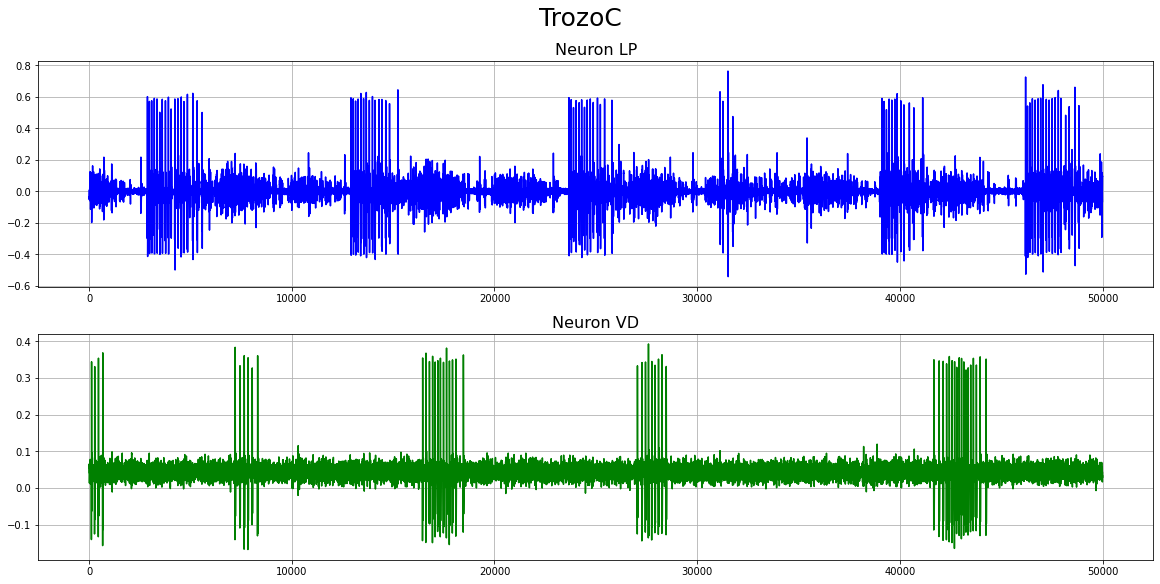

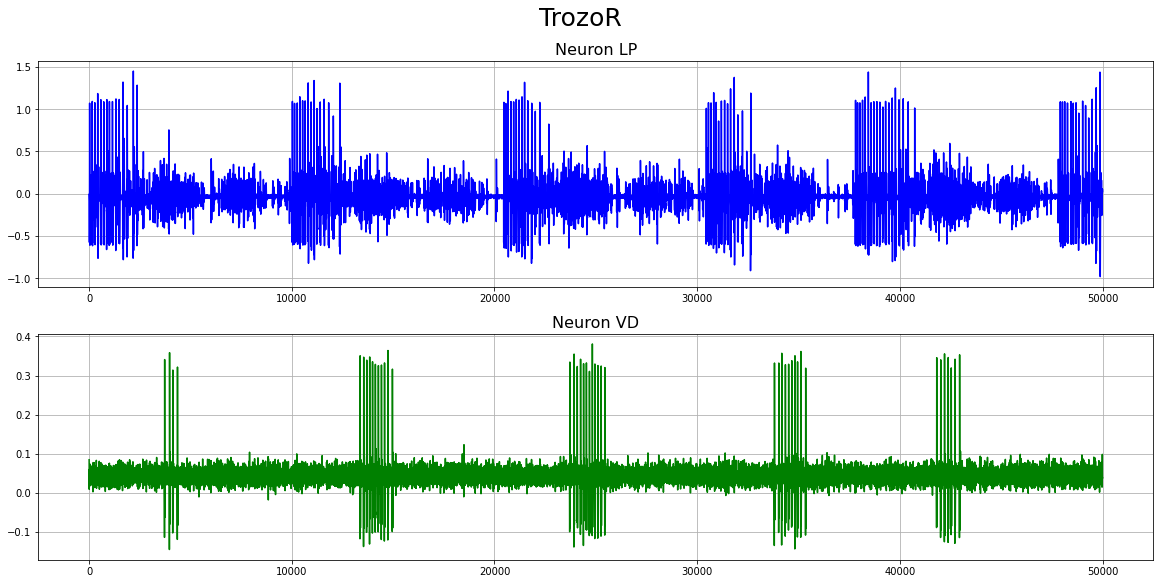

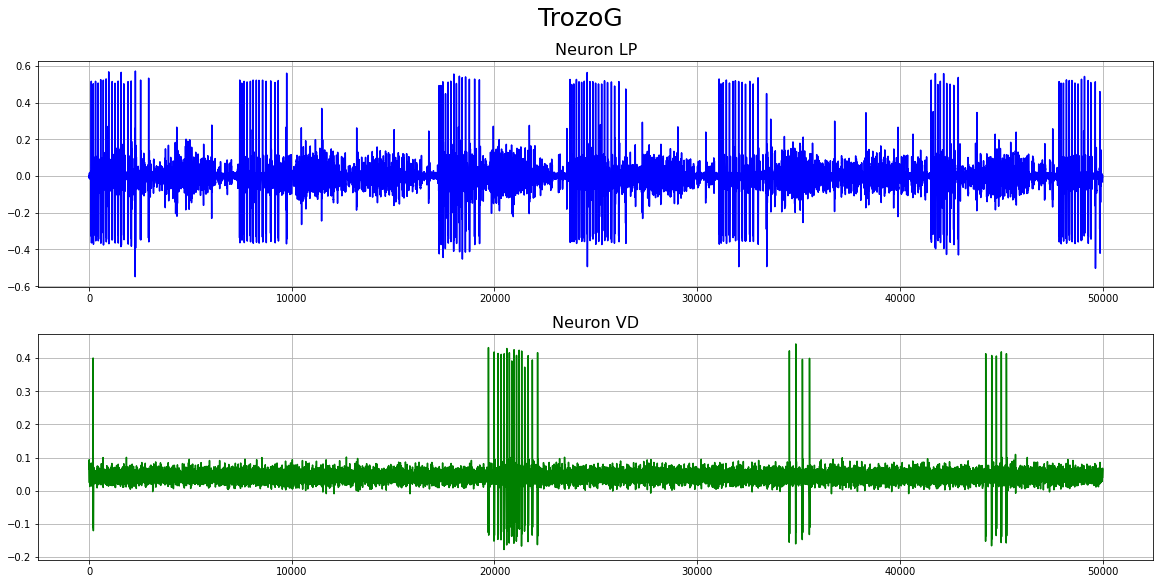

In [ ]:
max_points_plotted = 50000

for trozo_name, trozo in zip(TROZOS_NAMES, trozos):
  plot_data(trozo, trozo_name, max_points_plotted)

In [ ]:
def get_threshold(np_array: np.ndarray) -> float:
    percentage_to_find_outliers = 0.021 # https://es.wikipedia.org/wiki/Regla_68-95-99.7
    np_array_sorted = -np.sort(-np_array)
    min_of_max_index = int(percentage_to_find_outliers * len(np_array)) 
    mean_of_max_values = np_array_sorted[:min_of_max_index].mean()
    return mean_of_max_values 

In [ ]:
DICT_OF_THRESHOLDS = dict()

for trozo_name, trozo in zip(TROZOS_NAMES, trozos):
  DICT_OF_THRESHOLDS[trozo_name] = dict()
  for neuron_name in NEURON_NAMES:
    DICT_OF_THRESHOLDS[trozo_name][neuron_name] = get_threshold(
        trozo[neuron_name].to_numpy()
    )

In [ ]:
threshold_list = list()

for trozo_name in TROZOS_NAMES:
  threshold_list.append(
    ["Threshold of {}".format(trozo_name), 
      DICT_OF_THRESHOLDS[trozo_name][NEURON_NAMES[0]], 
      DICT_OF_THRESHOLDS[trozo_name][NEURON_NAMES[1]]]    
  )

print(tabulate(threshold_list, headers=NEURON_NAMES, floatfmt=".3f", tablefmt='fancy_grid'))

╒═════════════════════╤═══════╤═══════╕
│                     │    LP │    VD │
╞═════════════════════╪═══════╪═══════╡
│ Threshold of TrozoC │ 0.308 │ 0.176 │
├─────────────────────┼───────┼───────┤
│ Threshold of TrozoR │ 0.754 │ 0.178 │
├─────────────────────┼───────┼───────┤
│ Threshold of TrozoG │ 0.312 │ 0.172 │
╘═════════════════════╧═══════╧═══════╛


## **3. Analysis of the bin size range**

The objective of this section is to **determine the range of values that the bin size can take**. The minimum bin size will be 1 and to calculate the maximum bin size we will use brute force incrementing one by one the bin size until we lose a maximum of a 5% of the total of the spikes.

As this calculation takes some time (30 minutes) we will store the output in a pickle file.

Steps:
1. Binarize the data with its respective threshold. Note that we only establish a point as spike if in addition of being above the threshold, this is a local maximum.
2. Visualize the binarized data
3. Calculate the maximum bin size for each "trozo", that will be the minimum between the maximum bin size of the two neurons.
4. Generate a dict with the bin size list of each "trozo". As the calculation of the mutual information, in addition to the other metrics, is computationally expensive we will increment the bin size in 4 units each time until we arrive to the maximum bin size calculated previously. Finally, such information will be stored in a dict called **"BIN_SIZE_DICT"**.


In [ ]:
def get_data_binarized(np_array: np.ndarray, threshold: float) -> np.ndarray:
  res_list = list()
  SPIKE, NO_SPIKE = 1, 0

  for index, val in enumerate(np_array):
    if val >= threshold and val == max(val, np_array[index-1], np_array[index+1]):
      res_list.append(SPIKE)
    else:
      res_list.append(NO_SPIKE)
      
  return np.array(res_list)

In [ ]:
dict_of_binarized_data = dict()

for trozo_name, trozo in zip(TROZOS_NAMES, trozos):
  dict_of_binarized_data[trozo_name] = dict()
  for neuron_name in NEURON_NAMES:
    data_binarized = get_data_binarized(
        trozo[neuron_name].to_numpy(),
        DICT_OF_THRESHOLDS[trozo_name][neuron_name]
    )
    dict_of_binarized_data[trozo_name][neuron_name] = data_binarized

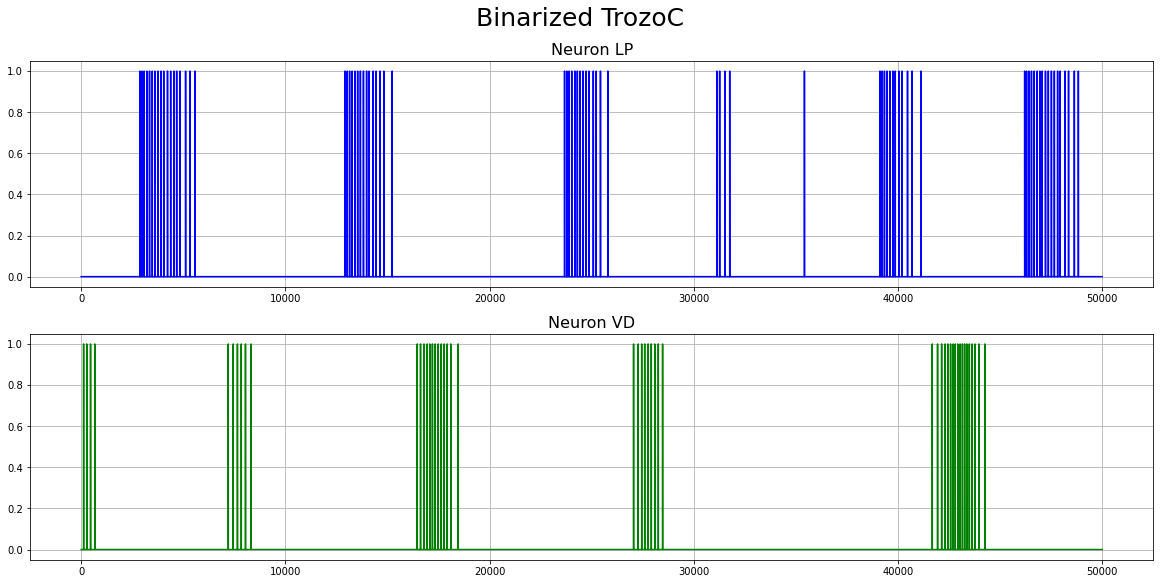

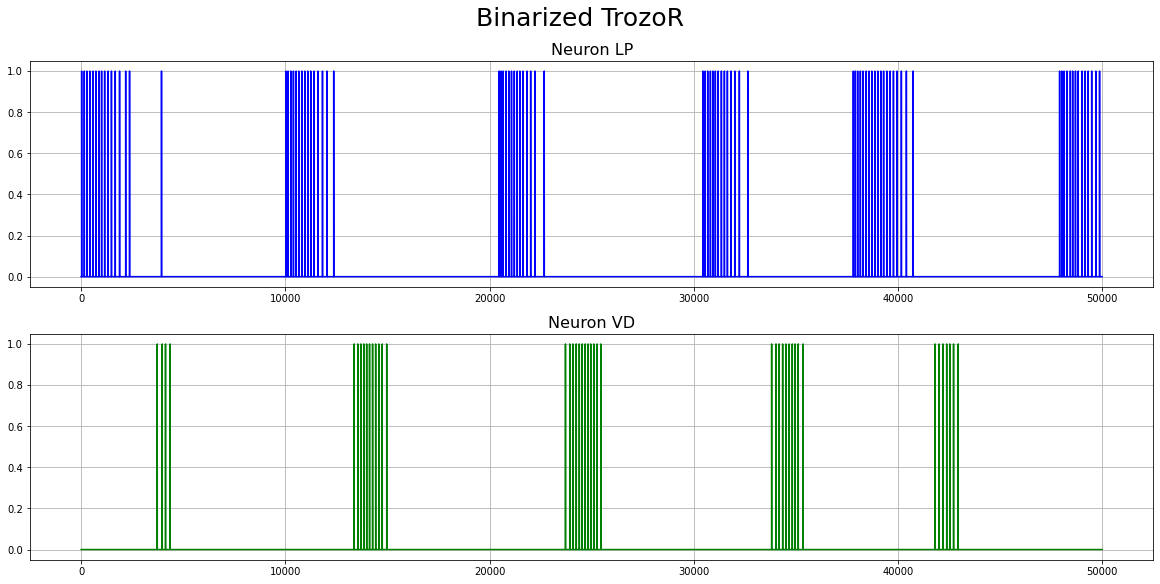

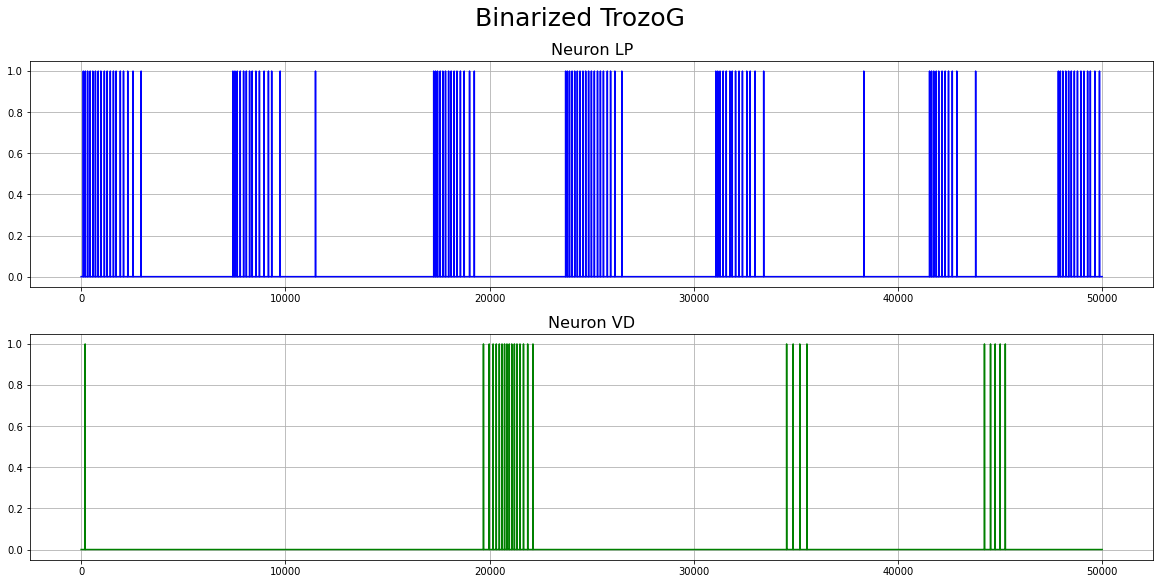

In [ ]:
max_points_plotted = 50000

for trozo_name in TROZOS_NAMES:
  plot_data(
      DataFrame(
          {NEURON_NAMES[0]: dict_of_binarized_data[trozo_name][NEURON_NAMES[0]], 
          NEURON_NAMES[1]: dict_of_binarized_data[trozo_name][NEURON_NAMES[1]]}
      ), 
      "Binarized {}".format(trozo_name), max_points_plotted
  )

In [ ]:
def get_data_codified_by_bin_size(np_array_binarized: np.ndarray,
                                  bin_size: int) -> np.ndarray:
    res_list = list()
    start = end = 0
    amount_of_iterations = int(len(np_array_binarized) / bin_size) + 1

    for index in range(1, amount_of_iterations):
        start = end
        end = bin_size * index
        chunk = np_array_binarized[start: end]
        res_list.append(_get_chunk_codified(chunk))
    
    res_list.append(_get_chunk_codified(np_array_binarized[end:]))
    return np.array(res_list)


def _get_chunk_codified(chunk: np.ndarray) -> int:
    SPIKE, NO_SPIKE = 1, 0
    if SPIKE in chunk:
        return SPIKE
    else:
        return NO_SPIKE

In [ ]:
def get_max_bin_size(np_array_binarized: np.ndarray, 
                     max_amount_iterations: int, 
                     max_percentage_skipped: float) -> int:
  total_amount_of_spikes = sum(np_array_binarized)
  max_skipped_spikes = total_amount_of_spikes * max_percentage_skipped

  for bin_size in range(2, max_amount_iterations+1):
    data_codified_by_bin_size = get_data_codified_by_bin_size(np_array_binarized, bin_size)
    amount_of_spikes = sum(data_codified_by_bin_size)
    if (total_amount_of_spikes-amount_of_spikes) > max_skipped_spikes:
      return bin_size-1
  
  return max_amount_iterations

In [ ]:
max_amount_iterations = 200
max_percentage_skipped = 0.05
dict_of_max_bin_size = dict()

for trozo_name in TROZOS_NAMES:
  neuron_LP_max_bin_size = get_max_bin_size(
      dict_of_binarized_data[trozo_name][NEURON_NAMES[0]],
      max_amount_iterations,
      max_percentage_skipped 
  ) 
  neuron_VD_max_bin_size = get_max_bin_size(
      dict_of_binarized_data[trozo_name][NEURON_NAMES[1]],
      max_amount_iterations,
      max_percentage_skipped 
  )  

  dict_of_max_bin_size[trozo_name] = min(
      neuron_LP_max_bin_size, neuron_VD_max_bin_size
  )

# Save the info calculated into a pickle file
with open('dict_of_max_bin_size.pickle', 'wb') as handle:
    pickle.dump(dict_of_max_bin_size, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load the info calculated from a pickle file
with open('{}dict_of_max_bin_size.pickle'.format(path_name), 'rb') as handle:
    dict_of_max_bin_size = pickle.load(handle)

In [ ]:
MIN_BIN_SIZE = 1
bin_size_tabulate_list = list()

for trozo_name in TROZOS_NAMES:
  bin_size_tabulate_list.append(
      ["Bin size of {}".format(trozo_name), MIN_BIN_SIZE, dict_of_max_bin_size[trozo_name]]
  )

print(tabulate(bin_size_tabulate_list, headers=["MIN_VALUE", "MAX_VALUE"], floatfmt=".2f", tablefmt='fancy_grid'))

╒════════════════════╤═════════════╤═════════════╕
│                    │   MIN_VALUE │   MAX_VALUE │
╞════════════════════╪═════════════╪═════════════╡
│ Bin size of TrozoC │           1 │         122 │
├────────────────────┼─────────────┼─────────────┤
│ Bin size of TrozoR │           1 │         118 │
├────────────────────┼─────────────┼─────────────┤
│ Bin size of TrozoG │           1 │         130 │
╘════════════════════╧═════════════╧═════════════╛


In [ ]:
BIN_SIZE_INTERVAL = 4

def get_bin_size_list(min_bin_size: int, 
                      max_bin_size: int, 
                      bin_size_interval: int) -> List[int]:
                      
  bin_size_list = [bin_size for bin_size in range(min_bin_size, 
                                                  max_bin_size, 
                                                  bin_size_interval)]
  bin_size_list.append(max_bin_size)
  return bin_size_list

In [ ]:
BIN_SIZE_DICT = dict()

for trozo_name in TROZOS_NAMES:
  BIN_SIZE_DICT[trozo_name] = get_bin_size_list(
      MIN_BIN_SIZE, 
      dict_of_max_bin_size[trozo_name], 
      BIN_SIZE_INTERVAL
  )

## **4. Entropy and Mutual Information computation**

The objective of this section is to **calculate the metrics** mathematically defined at the start of the present work:
1. Entropy of the LP neuron
2. Entropy of the VD neuron
3. Mutual Information
4. Information Transmission from LP to VD
5. Information Transmission from VD to LP

Steps:
1. Develop a couple of functions in order to be able to manipulate the data into words and into sliding words. Note that when we actually use these functions the data will not be only binarized but it will be aggregated in different bin sizes.
2. Create a function to calculate the probabilities of all the event that happens and another to calculate the equivalent but for the joint probabilities.
3. Develop one function per metric desired, that is, one for the entropy, other for mutual information and another for the transmission of the information.
4. Bring everything together and store the mentioned information in a dict of three levels:
  - LEVEL 0 of the dictionary contains "TozoC, G and R" as keys. 
  - LEVEL 1 of the dictionary contains the bin size $\Delta t$ as keys. 
  - LEVEL 2 of the dictionary contains the word size as keys and a list as a value containing the five values mentioned above.

  We will compute two of those dictionaries: one for the non-sliding words, which will be called **"main_metrics_dict"** and another for the sliding words which will be called **"main_metrics_sliding_dict"**. Both of them will be stored as a pickle file too for efficiency reasons.

In [ ]:
WORD_SIZE_LIST = [word_size for word_size in range(1, 9)]

def get_data_codified_by_word_size(np_array_binarized: np.ndarray, 
                                   word_size: int) -> np.ndarray:
    res_list = list()
    start = end = 0
    amount_of_iterations = int(len(np_array_binarized) / word_size) 

    for index in range(1, amount_of_iterations+1):
        start = end
        end = word_size * index
        chunk = np_array_binarized[start: end]
        res_list.append("".join([str(e) for e in chunk]))

    return np.array(res_list) 


def get_data_codified_by_sliding_word_size(np_array_binarized: np.ndarray, 
                                           sliding_word_size: int) -> np.ndarray:
    res_list = list()
    start = 0
    end = sliding_word_size
    amount_of_iterations = len(np_array_binarized)-sliding_word_size + 1

    for _ in range(amount_of_iterations):
        chunk = np_array_binarized[start: end]
        res_list.append("".join([str(e) for e in chunk]))
        start += 1
        end += 1

    return np.array(res_list)

In [ ]:
def get_dict_of_probabilities(np_array_str: np.ndarray) -> Dict[str, float]:
  res_dict = dict()
  dict_of_occurrences = _get_dict_of_occurrences(np_array_str)
  len_np_array_str = len(np_array_str)
  
  for event, occurrences in dict_of_occurrences.items():
    probability = occurrences / len_np_array_str
    res_dict[event] = probability

  return res_dict


def _get_dict_of_occurrences(np_array_str: np.ndarray) -> Dict[str, int]:
    res_dict = dict()
    
    for val_str in np_array_str:
      if val_str in res_dict:
        res_dict[val_str] += 1
      else:
        res_dict[val_str] = 1
    
    return res_dict 


def get_dict_of_joint_probabilities(x_np_array_str: np.ndarray, 
                                    y_np_array_str: np.ndarray) -> Dict[str, float]:
  res_dict = dict()
  dict_of_occurrences = _get_dict_of_joint_occurrences(x_np_array_str, 
                                                       y_np_array_str)
  len_np_array_str = len(x_np_array_str)

  for event, occurrences in dict_of_occurrences.items():
    joint_probability = occurrences / len_np_array_str
    res_dict[event] = joint_probability

  return res_dict


def _get_dict_of_joint_occurrences(x_np_array_str: np.ndarray, 
                                   y_np_array_str: np.ndarray) -> Dict[str, int]:
    res_dict = dict()
    
    for x_val_str, y_val_str in zip(x_np_array_str, y_np_array_str):
      joint_val_str = x_val_str + "|" + y_val_str
      if joint_val_str in res_dict:
        res_dict[joint_val_str] += 1
      else:
        res_dict[joint_val_str] = 1
    
    return res_dict 

In [ ]:
def get_entropy(dict_of_probabilities: Dict[str, float]) -> float:
  return -sum([prob * math.log2(prob) for prob in dict_of_probabilities.values()])


def get_mutual_information(dict_of_x_probabilities:  Dict[str, float],
                           dict_of_y_probabilities:  Dict[str, float],
                           dict_of_joint_probabilities:  Dict[str, float]) -> float:
  res = 0

  for event, joint_probability in dict_of_joint_probabilities.items():
    x_event, y_event = event.split("|")
    x_probability = dict_of_x_probabilities[x_event]
    y_probability = dict_of_y_probabilities[y_event]

    res += joint_probability * math.log2(joint_probability / (x_probability * y_probability))

  return res


def get_transmission_of_information(mutual_information: float, entropy: float) -> float:
  return mutual_information / entropy


In [ ]:
def get_main_metrics_dict(dict_of_binarized_data: Dict[str, Dict[str, np.ndarray]],
                          trozos_names: List[str],
                          bin_size_dict: Dict[str, int],
                          word_size_list: List[int],
                          sliding_word_size=False) -> Dict[str, Dict[int, Dict[int, List[float]]]]:
  
  main_metrics_dict = dict() # main_metrics_dict[trozo_name][bin_size][word_size](entropyLP, entropyVD, MI, transLP, transVD)
  
  for trozo_name in tqdm(trozos_names):
    main_metrics_dict[trozo_name] = dict()
    for bin_size in tqdm(bin_size_dict[trozo_name]):
      main_metrics_dict[trozo_name][bin_size] = dict()
      neuron_LP_codified_by_bin_size = get_data_codified_by_bin_size(
          dict_of_binarized_data[trozo_name][NEURON_NAMES[0]], bin_size
      )
      neuron_VD_codified_by_bin_size = get_data_codified_by_bin_size(
          dict_of_binarized_data[trozo_name][NEURON_NAMES[1]], bin_size
      )
      for word_size in tqdm(word_size_list):
        main_metrics_dict[trozo_name][bin_size][word_size] = list()

        if sliding_word_size:
          neuron_LP_codified_by_word_size = get_data_codified_by_sliding_word_size(
              neuron_LP_codified_by_bin_size, word_size
          )
          neuron_VD_codified_by_word_size = get_data_codified_by_sliding_word_size(
              neuron_VD_codified_by_bin_size, word_size
          )
        else:
          neuron_LP_codified_by_word_size = get_data_codified_by_word_size(
              neuron_LP_codified_by_bin_size, word_size
          )
          neuron_VD_codified_by_word_size = get_data_codified_by_word_size(
              neuron_VD_codified_by_bin_size, word_size
          )

        neuron_LP_dict_of_probabilities = get_dict_of_probabilities(neuron_LP_codified_by_word_size)
        neuron_VD_dict_of_probabilities = get_dict_of_probabilities(neuron_VD_codified_by_word_size)
        trozo_dict_of_joint_probabilities = get_dict_of_joint_probabilities(
            neuron_LP_codified_by_word_size, neuron_VD_codified_by_word_size
        )

        nueron_LP_entropy = get_entropy(neuron_LP_dict_of_probabilities)
        nueron_VD_entropy = get_entropy(neuron_VD_dict_of_probabilities)
        mutual_information = get_mutual_information(
            neuron_LP_dict_of_probabilities, 
            neuron_VD_dict_of_probabilities,
            trozo_dict_of_joint_probabilities
        )
        nueron_LP_transmission_of_information = get_transmission_of_information(
            mutual_information, nueron_LP_entropy
        )
        nueron_VD_transmission_of_information = get_transmission_of_information(
            mutual_information, nueron_VD_entropy
        )

        main_metrics = [
            nueron_LP_entropy, nueron_VD_entropy, mutual_information,
            nueron_LP_transmission_of_information, nueron_VD_transmission_of_information
        ]

        main_metrics_dict[trozo_name][bin_size][word_size].extend(main_metrics)
  
  return main_metrics_dict


In [ ]:
main_metrics_dict = get_main_metrics_dict(
    dict_of_binarized_data,
    TROZOS_NAMES,
    BIN_SIZE_DICT,
    WORD_SIZE_LIST
)

# Save the info calculated into a pickle file (1 h)
with open('main_metrics.pickle', 'wb') as handle:
    pickle.dump(main_metrics_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Para cargar el dict con las métricas
with open('{}main_metrics.pickle'.format(path_name), 'rb') as handle:
    main_metrics_dict = pickle.load(handle)

In [ ]:
main_metrics_sliding_dict = get_main_metrics_dict(
    dict_of_binarized_data,
    TROZOS_NAMES,
    BIN_SIZE_DICT,
    WORD_SIZE_LIST,
    sliding_word_size=True
)

# Save the info calculated into a pickle file (2 h 50 mins)
with open('main_metrics_sliding.pickle', 'wb') as handle:
    pickle.dump(main_metrics_sliding_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load the info calculated from a pickle file
with open('{}main_metrics_sliding.pickle'.format(path_name), 'rb') as handle:
    main_metrics_sliding_dict = pickle.load(handle)

It is important to note the use of the following script used in the browser developer console, so that Google Colab does not stop execution due to inactivity:

var rand = 90000;

function ClickConnect() {
console.log("Working"); 
rand = Math.round(Math.random()*(90000-30000))+30000;
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect, rand)

## **5. Results and visualizations**

The objective of this section is to **visualize the computed metrics** of the previous section.

Note that when we normalize the data what we refer is that we divide the input between the output of the multiplication of its respective bin size per word size.

In [ ]:
def extract_data_from_dict(d: Dict[str, Dict[int, Dict[int, List[float]]]], 
                          data_dict: Dict[int,str], 
                          data_index: int,    
                          trozo: str,        
                          normalize=True,   
                          )-> List[float]:
  res_list = [[],[],[],[],[],[],[],[]]
  dt = d[trozo]
  
  for binsize in dt.keys():
    dbins = dt[binsize]
    for wordsize in dbins.keys():
      dwords = dbins[wordsize]
      if normalize: 
        res_list[wordsize-1].append(dwords[data_index]/(wordsize*binsize))
      else:
        res_list[wordsize-1].append(dwords[data_index])

  return res_list

def plot_results(d,data_dict,data_index,normalize):
  fig,ax = plt.subplots(1,3,figsize=(15,6),tight_layout=True)

  for trozo in trozo_dict.keys():
    res = extract_data_from_dict(d,
                              data_dict,
                              data_index=data_index,
                              trozo=trozo,
                              normalize=normalize)
    for index,el in enumerate(res):
      ax[trozo_dict[trozo]].plot(np.arange(1,len(el)*4,4),el,label=str(index+1)+' bits')
      ax[trozo_dict[trozo]].set_title(trozo,fontsize=25)
      ax[trozo_dict[trozo]].set_xlabel(r'Binsize $\Delta t$',fontsize=20)
      ax[trozo_dict[trozo]].set_ylabel(data_dict[data_index],fontsize=20)
      ax[trozo_dict[trozo]].tick_params(axis='both', which='both', labelsize=15)
  ax[trozo_dict[trozo]].legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=12)


In [ ]:
data_dict = {0: 'LP entropy',
             1: 'VD entropy',
             2: 'MI Normalized',
             3: 'Transmission LP->VD Normalized',
             4: 'Transmission VD->LP Normalized'}

trozo_dict={'TrozoC': 0,
            'TrozoG': 1,
            'TrozoR': 2}

## Results for a **fixed word** mapping

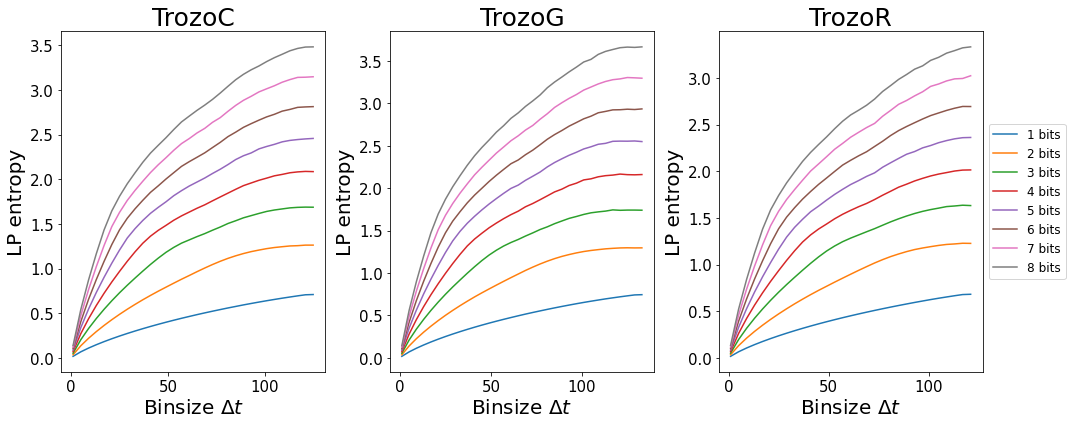

In [ ]:
plot_results(main_metrics_dict, data_dict, 0, normalize=False)

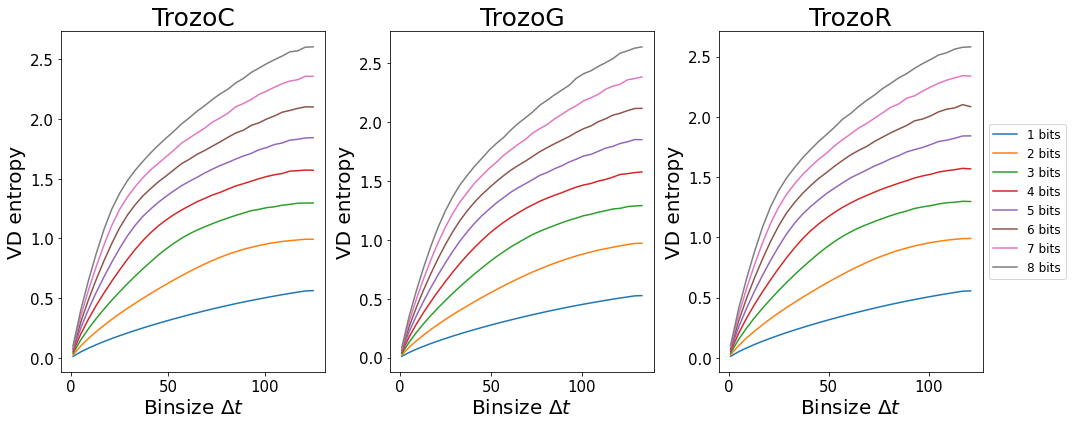

In [ ]:
plot_results(main_metrics_dict, data_dict, 1, normalize=False)

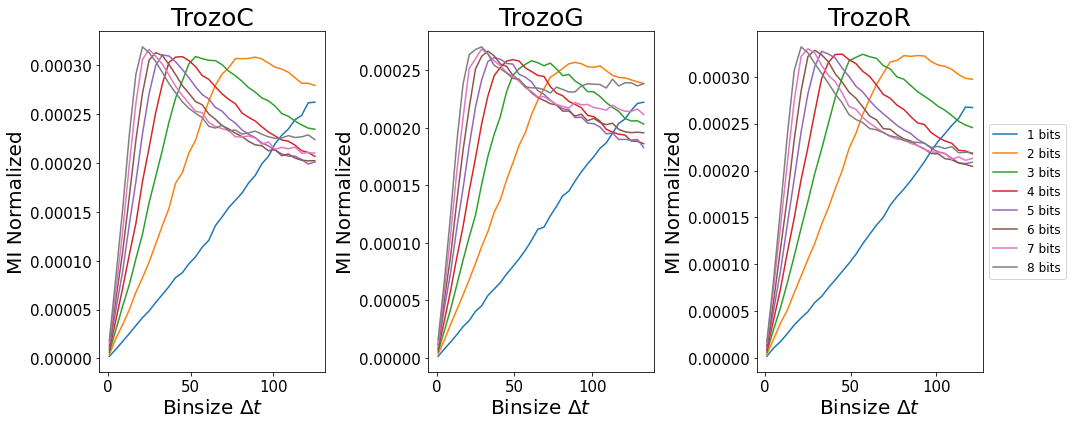

In [ ]:
plot_results(main_metrics_dict, data_dict, 2, normalize=True)

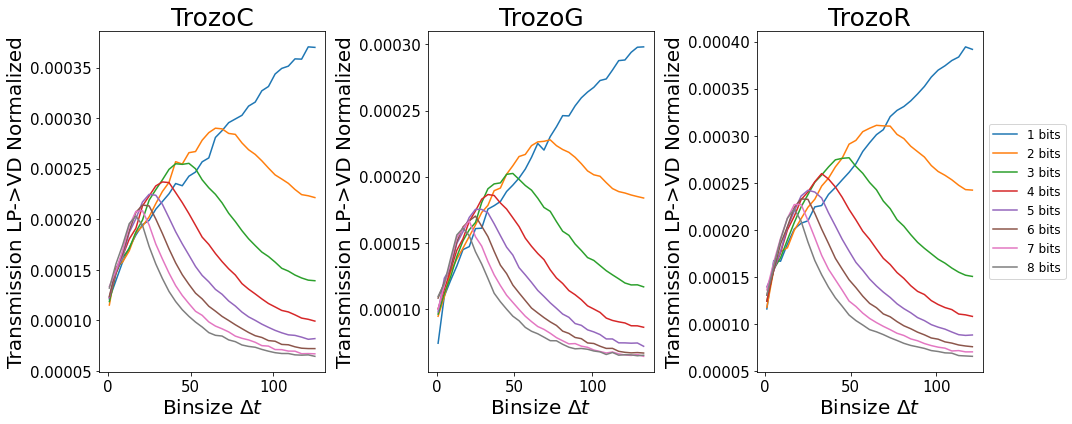

In [ ]:
plot_results(main_metrics_dict, data_dict, 3, normalize=True)

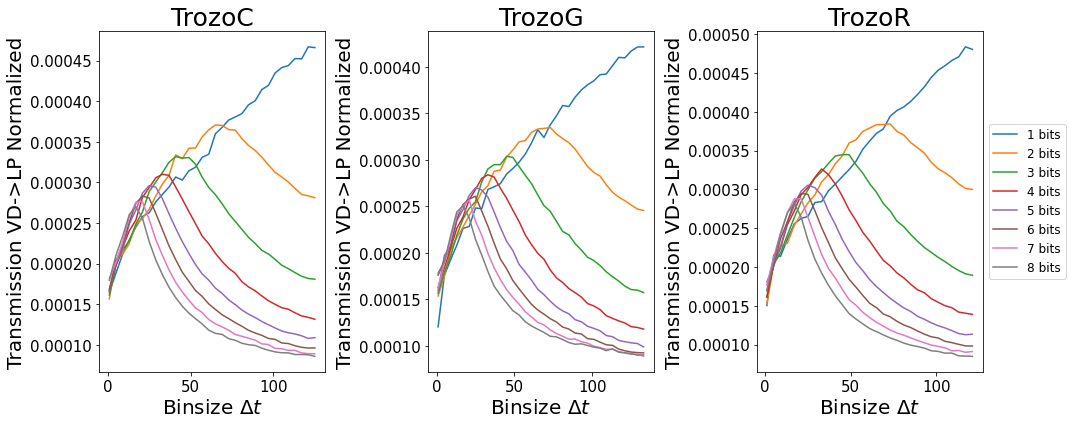

In [ ]:
plot_results(main_metrics_dict, data_dict, 4, normalize=True)

## Results for **sliding word** mapping

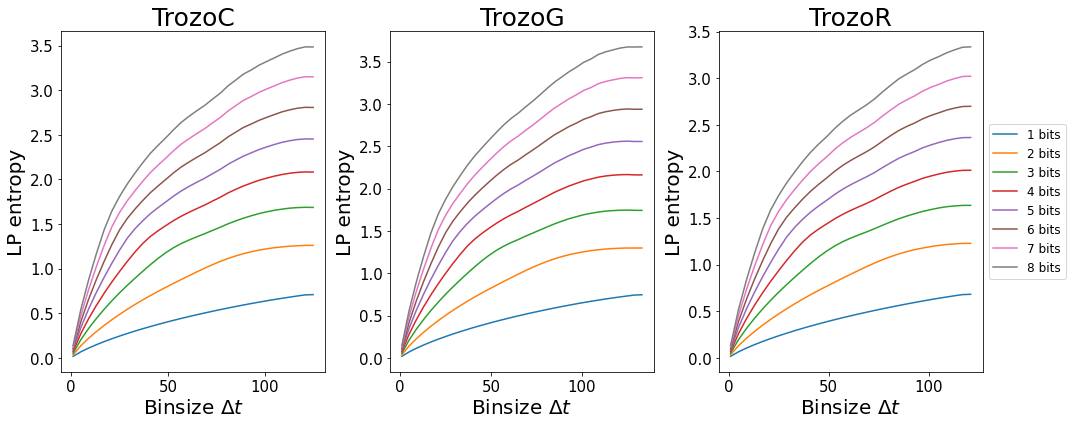

In [ ]:
plot_results(main_metrics_sliding_dict, data_dict, 0, normalize=False)

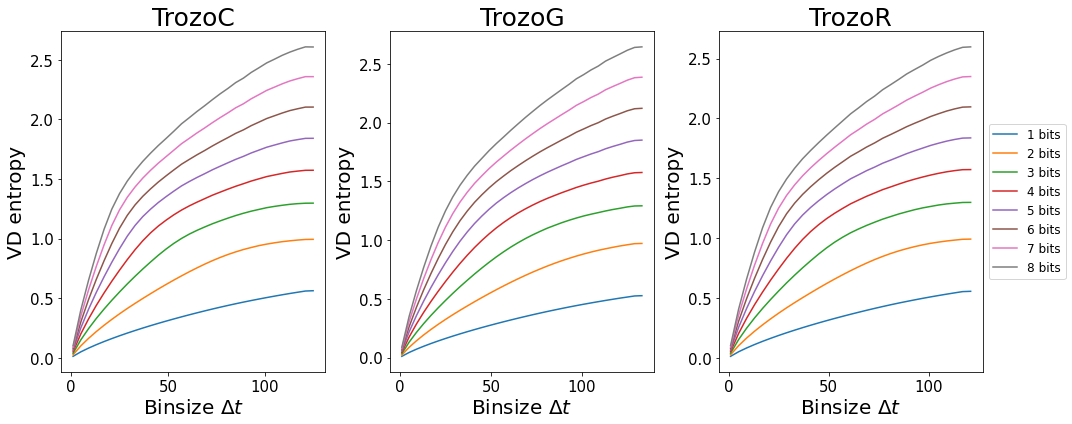

In [ ]:
plot_results(main_metrics_sliding_dict, data_dict, 1, normalize=False)

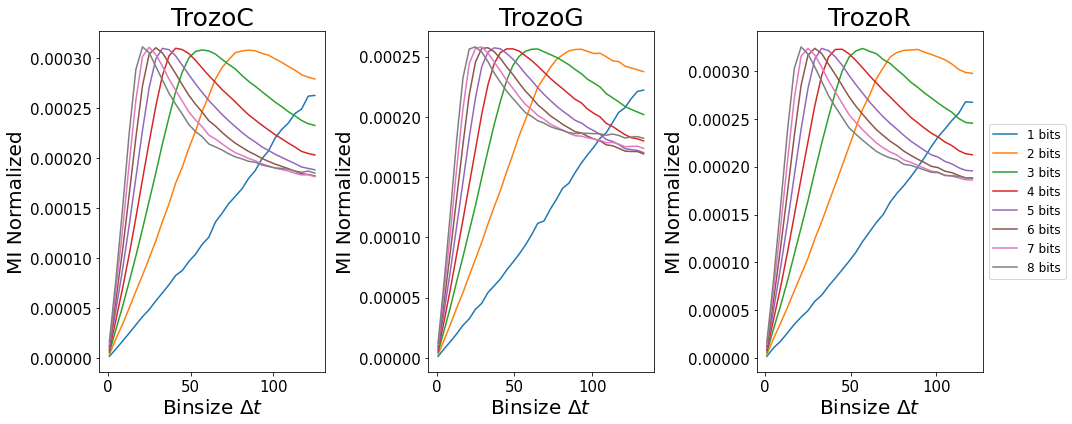

In [ ]:
plot_results(main_metrics_sliding_dict, data_dict, 2, normalize=True)

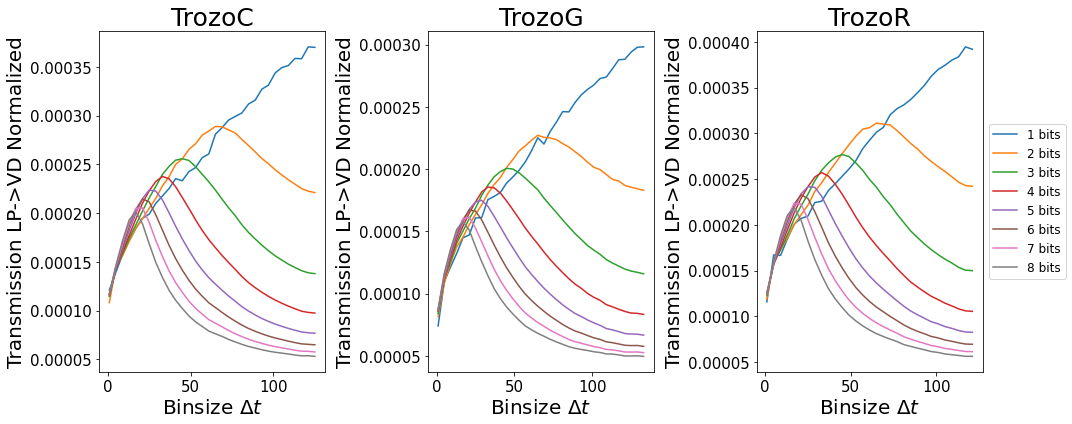

In [ ]:
plot_results(main_metrics_sliding_dict, data_dict, 3, normalize=True)

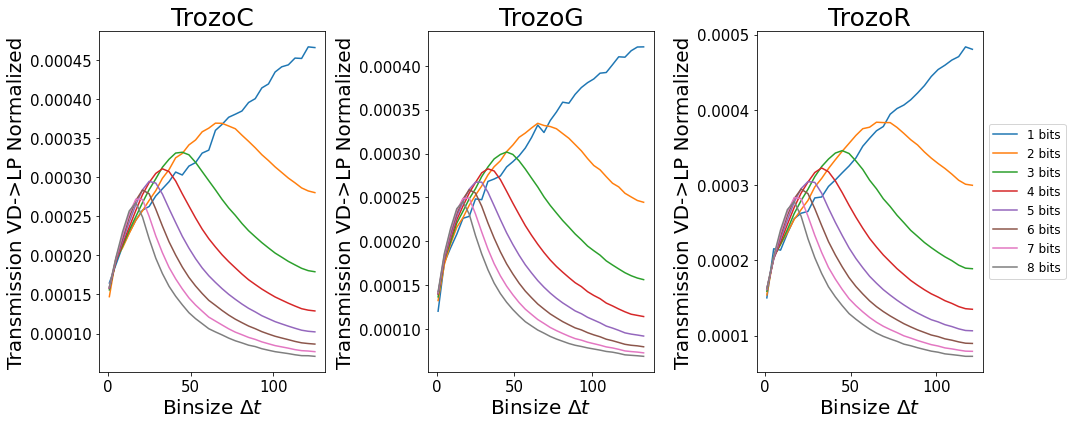

In [ ]:
plot_results(main_metrics_sliding_dict, data_dict, 4, normalize=True)

## **6. Entropy and mutual information after SAX transformation [3]**

### Example of using SAX to transform the signal from neuron LP: 

Binning continuous data into intervals can be seen as an approximation that reduces noise and captures the trend of the neuron signal. The Symbolic Aggregate approXimation (SAX) algorithm bins continuous time series into intervals, transforming independently each time series (a sequence of floats) into a sequence of symbols, usually letters. This can potentially provide more information than a simple binary transformation. An example is shown in the next cells: 

A possible input would be: [ 0.004883  0.001526 -0.010681 -0.022278 -0.028076 -0.03418  -0.045166
 -0.048523 -0.049438 -0.048828 -0.04425  -0.039673 -0.036011 -0.035095
 -0.04364  -0.054932 -0.05188  -0.044556 -0.036621 -0.027771]


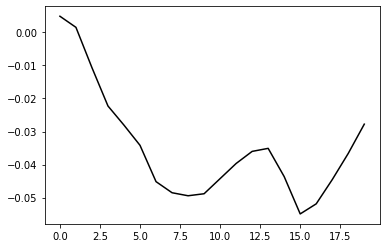

In [ ]:
trozoC = trozos[0][0:20] 
LP = trozoC['LP'].to_numpy()
print('A possible input would be:', LP)
plt.plot(LP,color='black')

In [ ]:
time = np.arange(0,len(LP),1)

transformer = SymbolicAggregateApproximation(n_bins=3)
print('And the output of SAX would be: ',transformer.fit_transform([LP,time])[0])

And the output of SAX would be:  ['c' 'c' 'c' 'c' 'c' 'c' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'a' 'a' 'a'
 'b' 'c']


The letters are assigned not only looking at the position of the point but also taking into account all values from the signal. This allows for a compact and complete transformation. In the next plot, the points above both lines were assigned the symbol "c", the points between the two lines were assigned the symbol "b" and the points below both lines were assigned the symbol "a". 

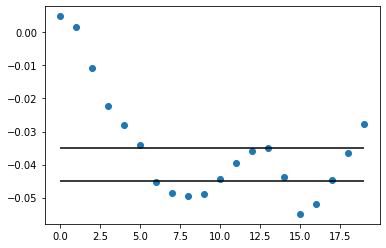

In [ ]:
plt.scatter(time,LP)
plt.hlines(y=-0.045,xmin=0,xmax=19)
plt.hlines(y=-0.035,xmin=0,xmax=19)

### Before applying SAX we transform the signal using Picewise Aggregate Aproximation. 

Piecewise Aggregate Approximation (PAA) is a very simple dimensionality reduction method for time series mining. It minimizes dimensionality by the mean values of equal sized frames. We will implement PAA using a variety of window sizes (in a similar way as we have done for binarizing) to see how it affects the main metrics. 

In the next cell, a 20.000 timestamps long signal is transforme into a 20 symbols array. Of course this is an oversimplification but shows how PAA can drastically reduce the dimension but at the same time coulda also lose important information. 

In [ ]:
trozoC = trozos[0]
LP = trozoC['LP'][0:20000].to_numpy()
time = np.arange(0,len(LP),1)

transformer = PiecewiseAggregateApproximation(window_size=1000)
new_LP,new_time=transformer.fit_transform([LP,time])

transformer = SymbolicAggregateApproximation(n_bins=5,strategy='quantile')
letters = transformer.fit_transform([new_LP])[0]
print(letters)

['b' 'c' 'a' 'e' 'd' 'd' 'c' 'c' 'b' 'e' 'b' 'd' 'c' 'a' 'e' 'a' 'e' 'a'
 'd' 'b']


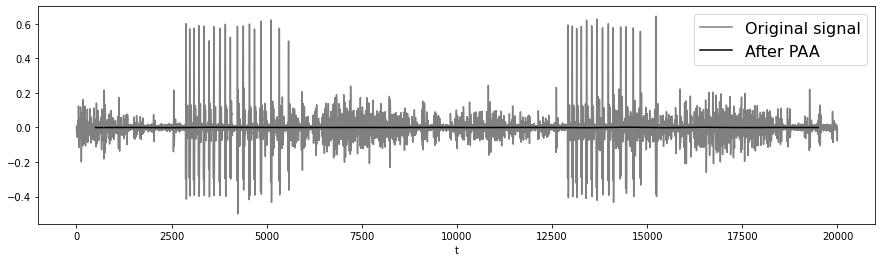

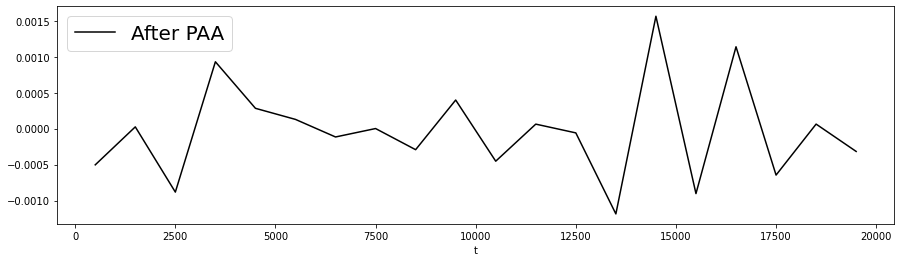

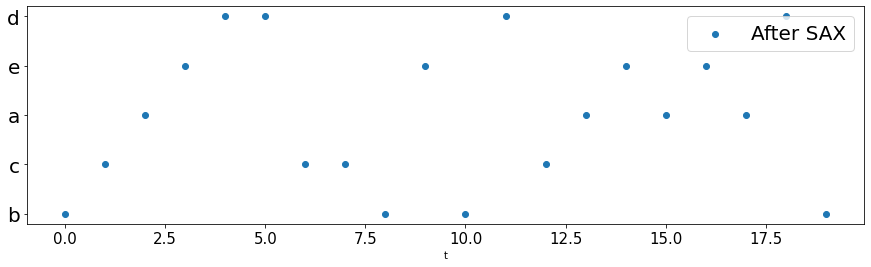

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(time,LP,c='gray',label='Original signal')
plt.plot(new_time,new_LP,c='black',label='After PAA')
plt.xlabel('t')
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(15,4))
plt.plot(new_time,new_LP,c='black',label='After PAA')
plt.legend(fontsize=20)
plt.xlabel('t')
plt.show()

plt.figure(figsize=(15,4))
plt.scatter(np.arange(0,20,1),transformer.fit_transform([new_LP,new_time])[0],label='After SAX')
plt.legend(fontsize=20)
plt.xlabel('t')
plt.yticks(fontsize=20)
plt.xticks(fontsize=15)
plt.show()

### Mutual Information and other important metrics for different averaging windows and word sizes and dictionary sizes

In [ ]:
def get_data_PAA_by_window_size(np_array_raw:np.ndarray,
                                window_size:int)->np.ndarray:
  res_list = list()
  time = np.arange(0,len(np_array_raw),1)

  transformer = PiecewiseAggregateApproximation(window_size=window_size)
  np_array_PAA=transformer.fit_transform([np_array_raw,time])[0]
  return np_array_PAA

def get_data_codified_by_SAX(np_array_PAA: np.ndarray,
                             size_dict: int)->np.ndarray:
  transformer = SymbolicAggregateApproximation(n_bins=size_dict,
                                               strategy='quantile')
  np_arrray_of_letters = transformer.fit_transform([np_array_PAA])[0]
  return np_arrray_of_letters 


In [ ]:
dict_of_raw_data = dict()

for trozo_name, trozo in zip(TROZOS_NAMES, trozos):
  dict_of_raw_data[trozo_name] = dict()
  for neuron_name in NEURON_NAMES:
    raw_data = trozo[neuron_name].to_numpy()
    dict_of_raw_data[trozo_name][neuron_name] = raw_data

In [ ]:
def get_main_metrics_dict_SAX(dict_of_raw_data: Dict[str, Dict[str, np.ndarray]],
                          trozos_names: List[str],
                          window_size_list: List[int],
                          word_size_list: List[int],
                          size_dict:int,
                          sliding_wordsize=False
                          ) -> Dict[str, Dict[int, Dict[int, List[float]]]]:
  
  main_metrics_dict = dict() # main_metrics_dict[trozo_name][bin_size][word_size](entropyLP, entropyVD, MI, transLP, transVD)
  
  for trozo_name in tqdm(trozos_names):
    main_metrics_dict[trozo_name] = dict()
    for window_size in window_size_list:
      
      main_metrics_dict[trozo_name][window_size] = dict()
      
      neuron_LP_codified_by_window_size = get_data_PAA_by_window_size(dict_of_raw_data[trozo_name][NEURON_NAMES[0]],
                                          window_size=window_size)

      neuron_VD_codified_by_window_size = get_data_PAA_by_window_size(dict_of_raw_data[trozo_name][NEURON_NAMES[1]],
                                          window_size=window_size)
      
      # Convert array of floats to array of strings (letters)
      neuron_LP_codified_by_SAX = get_data_codified_by_SAX(neuron_LP_codified_by_window_size,
                               size_dict=size_dict)
      neuron_VD_codified_by_SAX = get_data_codified_by_SAX(neuron_VD_codified_by_window_size,
                               size_dict=size_dict)

      
      for word_size in word_size_list:        
        main_metrics_dict[trozo_name][window_size][word_size] = list()

        if sliding_wordsize:
          neuron_LP_codified_by_word_size = get_data_codified_by_sliding_word_size(
              neuron_LP_codified_by_SAX, word_size
          )
          neuron_VD_codified_by_word_size = get_data_codified_by_sliding_word_size(
              neuron_VD_codified_by_SAX, word_size
          )
        else:
          neuron_LP_codified_by_word_size = get_data_codified_by_word_size(
              neuron_LP_codified_by_SAX, word_size
          )
          neuron_VD_codified_by_word_size = get_data_codified_by_word_size(
              neuron_VD_codified_by_SAX, word_size
          )



        neuron_LP_dict_of_probabilities = get_dict_of_probabilities(neuron_LP_codified_by_word_size) 
        neuron_VD_dict_of_probabilities = get_dict_of_probabilities(neuron_VD_codified_by_word_size)
        trozo_dict_of_joint_probabilities = get_dict_of_joint_probabilities(
            neuron_LP_codified_by_word_size, neuron_VD_codified_by_word_size
        )

        nueron_LP_entropy = get_entropy(neuron_LP_dict_of_probabilities)
        nueron_VD_entropy = get_entropy(neuron_VD_dict_of_probabilities)
        mutual_information = get_mutual_information(
            neuron_LP_dict_of_probabilities, 
            neuron_VD_dict_of_probabilities,
            trozo_dict_of_joint_probabilities
        )
        nueron_LP_transmission_of_information = get_transmission_of_information(
            mutual_information, nueron_LP_entropy
        )
        nueron_VD_transmission_of_information = get_transmission_of_information( 
            mutual_information, nueron_VD_entropy
        )

        main_metrics = [
            nueron_LP_entropy, nueron_VD_entropy, mutual_information,
            nueron_LP_transmission_of_information, nueron_VD_transmission_of_information
        ]

        main_metrics_dict[trozo_name][window_size][word_size].extend(main_metrics)
  
  return main_metrics_dict

Metrics for **fixed** words:

In [ ]:
window_size_list = np.arange(1, 146, 4)
word_size_list = [1, 2, 3, 4, 5, 6, 7, 8]

main_metrics_SAX = get_main_metrics_dict_SAX(
    dict_of_raw_data,
    TROZOS_NAMES,
    window_size_list,
    word_size_list,
    size_dict=3,
    sliding_wordsize=False
)

# Save the info calculated into a pickle file (37 min) 
with open('main_metrics_SAX.pickle', 'wb') as handle:
    pickle.dump(main_metrics_SAX, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 3/3 [39:42<00:00, 794.10s/it]


In [ ]:
# Load the info calculated from a pickle file
with open('{}main_metrics_SAX.pickle'.format(path_name), 'rb') as handle:
    main_metrics_SAX = pickle.load(handle)

Metrics for **sliding** words: 

In [ ]:
window_size_list = np.arange(41, 146, 4)
word_size_list = [1, 2, 3, 4, 5, 6, 7, 8]
main_metrics_SAX_sliding = get_main_metrics_dict_SAX(
    dict_of_raw_data,
    TROZOS_NAMES,
    window_size_list,
    word_size_list,
    size_dict=3,
    sliding_wordsize=True
)

# Save the info calculated into a pickle file (2 h 7 min) 
with open('main_metrics_SAX_sliding.pickle', 'wb') as handle:
    pickle.dump(main_metrics_SAX_sliding, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Load the info calculated from a pickle file
with open('{}main_metrics_SAX_sliding.pickle'.format(path_name), 'rb') as handle:
    main_metrics_SAX_sliding = pickle.load(handle)

### Visualization of metrics obtained from SAX for **fixed** words


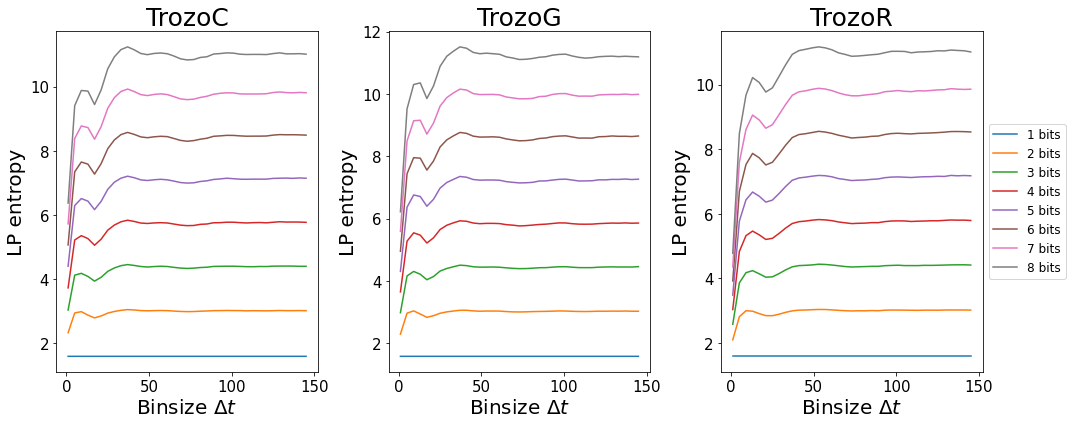

In [ ]:
plot_results(main_metrics_SAX,data_dict,0,normalize=False)

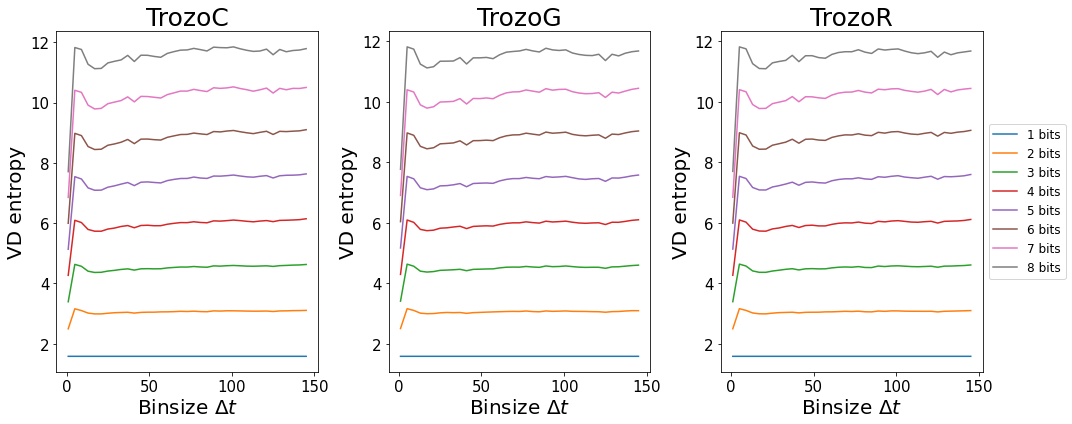

In [ ]:
plot_results(main_metrics_SAX,data_dict,1,normalize=False)

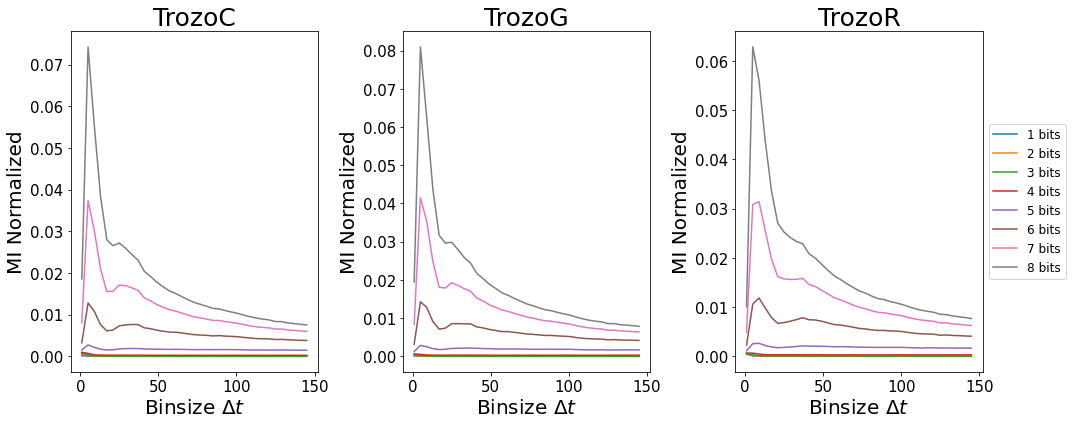

In [ ]:
plot_results(main_metrics_SAX,data_dict,2,normalize=True)

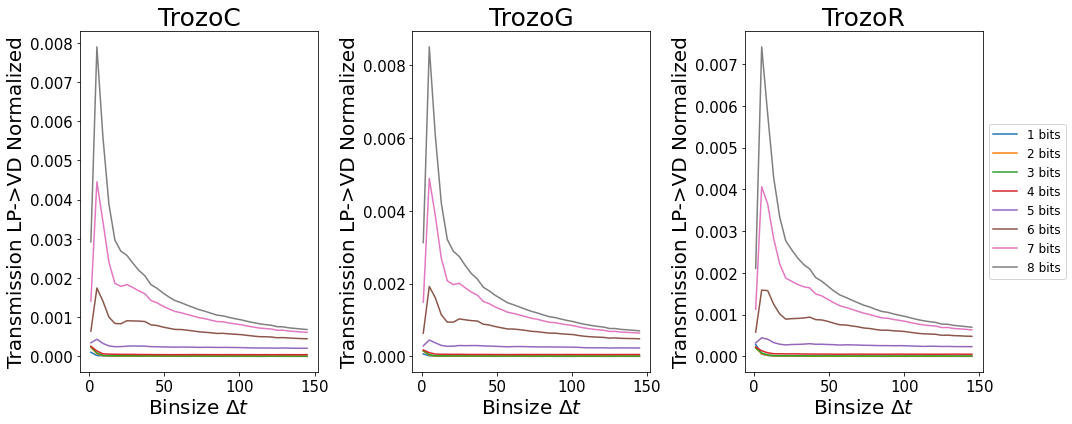

In [ ]:
plot_results(main_metrics_SAX,data_dict,3,normalize=True)

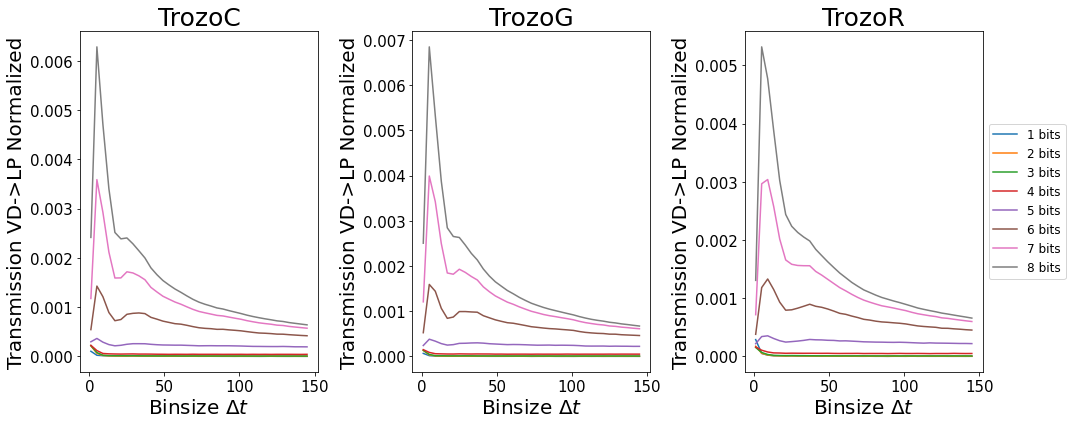

In [ ]:
plot_results(main_metrics_SAX,data_dict,4,normalize=True)

## **7. Findings and conclusions**

Having shown all the results obtained we proceed to visualize comparative plots in order to **draw conclusions from the data**. This will allow us to asses the fiability of the transformations used and compare behaviours between the 'C', 'G' and 'R' signals. 

In [ ]:
def plot_MI_comparative(d):
  fig,ax = plt.subplots(2,4,figsize=(20,9),
                        sharex='all', sharey='all',
                        tight_layout=False)
  
  fig.suptitle('Mutual Information \n normalized by binsize and wordsize',
               fontsize=20)

  for trozo in trozo_dict.keys():
    res = extract_data_from_dict(d,
                              data_dict,
                              2, #Mutual information
                              trozo=trozo,
                              normalize=True)

    for wordsize in range(0,4):
      ax[0,wordsize].plot(np.arange(1,len(res[wordsize])*4,4),res[wordsize])
      ax[0,wordsize].set_title('Wordsize='+str(wordsize+1)+'bits',
                               fontsize=15)
      ax[0,wordsize].set_ylabel('MI/(ws*bs)',fontsize=15)

      ax[1,wordsize].plot(np.arange(1,len(res[wordsize+4])*4,4),res[wordsize+4])
      ax[1,wordsize].set_title('Wordsize='+str(wordsize+5)+'bits',
                               fontsize=15)
      ax[1,wordsize].set_xlabel(r'$\Delta t$',fontsize=15)
      ax[1,wordsize].set_ylabel('MI/(ws*bs)',fontsize=15)
  plt.legend(['TrozoC','TrozoG','TrozoR'],fontsize=20)

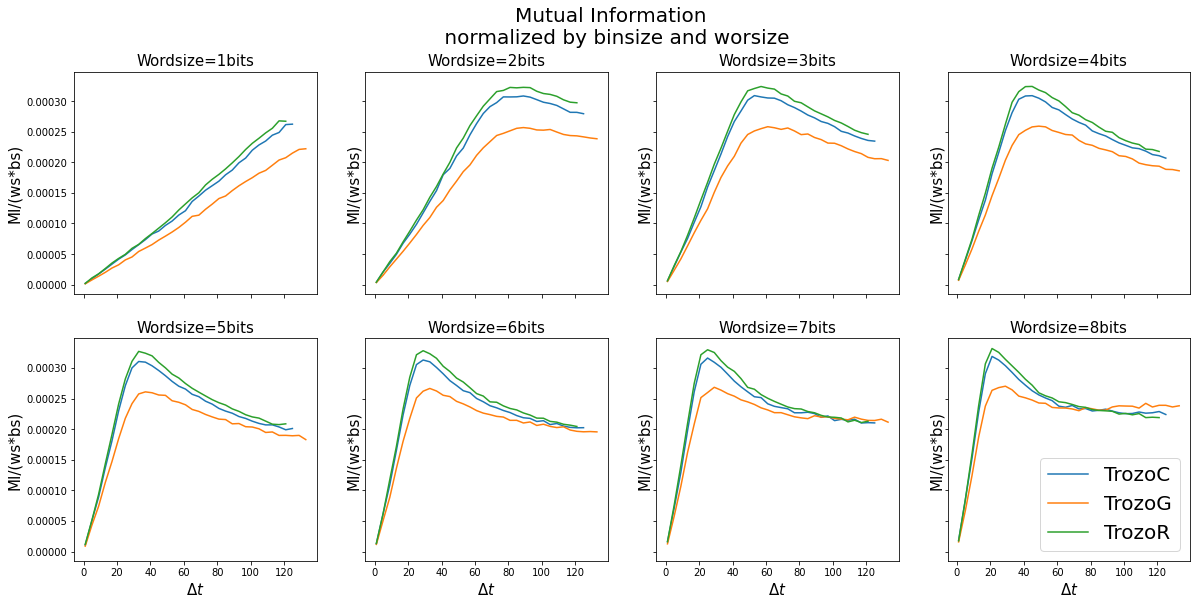

In [ ]:
plot_MI_comparative(main_metrics_dict)

### Window size - word size trade-off

The previous plots shows the mutual information between the two signals. Dividing by the word size and by $\Delta t$ is what results in the peak. This peak shows the maximum mutual information per bit and window size. It shows that we can not increase the window size arbitrarly without loosing relevant information. 

We can also appreciate a window size vs words size trade-off. On the one hand, for small words, the maximum MI is obtained for larger window sizes. On the other hand, larger words require smaller window sizes for achieveing the maximum Mutial Information.  

Regarding the distribution for each "Trozo" we can see how the Gabba injection produces a decrease in the Mutual Information between the two signals. Then the recuperation signal returns to the control MI levels and slightly surpasses them. 

In [ ]:
def plot_IT_comparative(d,trozo):
  fig,ax = plt.subplots(2,4,figsize=(20,9),
                        sharex='all', sharey='all',
                        tight_layout=False)
  
  fig.suptitle('Information Transmission {} \n normalized by binsize and wordsize'.format(trozo),
               fontsize=20)

  res1 = extract_data_from_dict(d,
                            data_dict,
                            3, #Mutual information
                            trozo=trozo,
                            normalize=True)
    
  res2 = extract_data_from_dict(d,
                            data_dict,
                            4, #Mutual information
                            trozo=trozo,
                            normalize=True)
  
  for wordsize in range(0,4):
    ax[0,wordsize].plot(np.arange(1,len(res1[wordsize])*4,4),res1[wordsize])
    ax[0,wordsize].plot(np.arange(1,len(res2[wordsize])*4,4),res2[wordsize])
    ax[0,wordsize].set_title('Wordsize='+str(wordsize+1)+'bits',
                              fontsize=15)
    ax[0,wordsize].set_ylabel('IT/(ws*bs)',fontsize=15)

    ax[1,wordsize].plot(np.arange(1,len(res1[wordsize+4])*4,4),res1[wordsize+4])
    ax[1,wordsize].plot(np.arange(1,len(res2[wordsize+4])*4,4),res2[wordsize+4])
    ax[1,wordsize].set_title('Wordsize='+str(wordsize+5)+'bits',
                              fontsize=15)
    ax[1,wordsize].set_xlabel(r'$\Delta t$',fontsize=15)
    ax[1,wordsize].set_ylabel('IT/(ws*bs)',fontsize=15)
  plt.legend(['LP->VD','VD->LP'],fontsize=20)

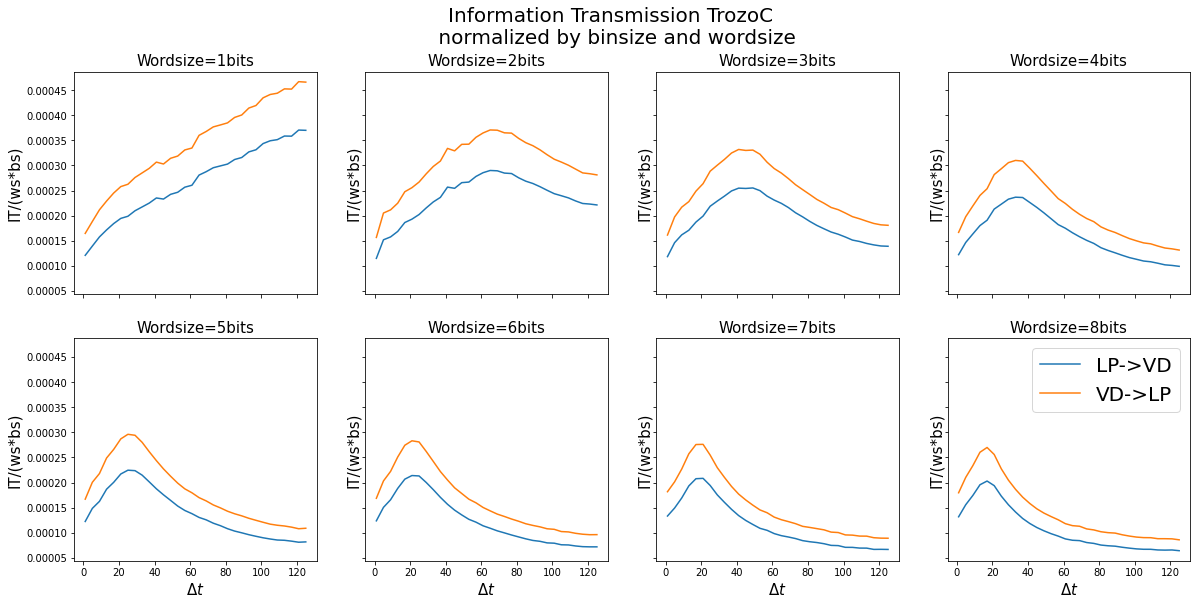

In [ ]:
plot_IT_comparative(main_metrics_dict,'TrozoC')

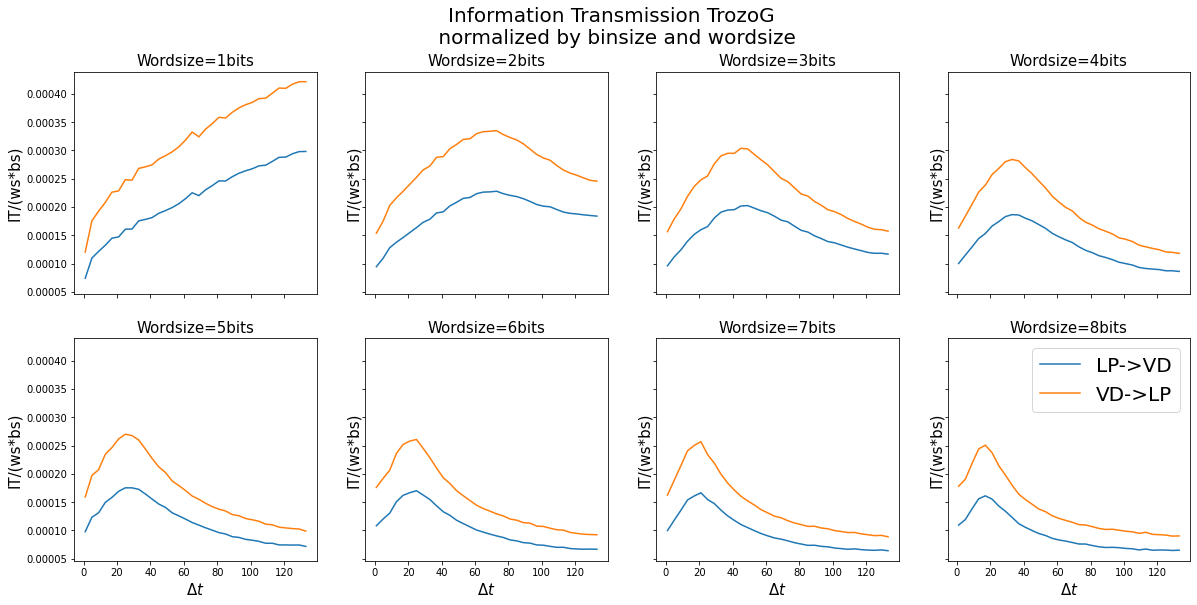

In [ ]:
plot_IT_comparative(main_metrics_dict,'TrozoG')

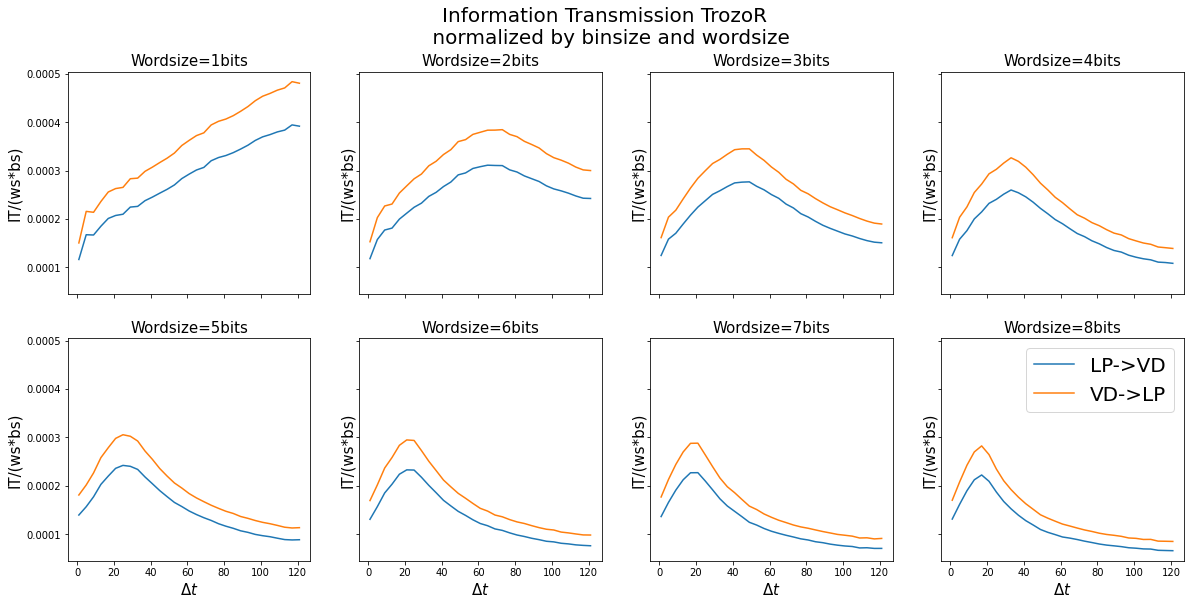

In [ ]:
plot_IT_comparative(main_metrics_dict,'TrozoR')

Having analyzed the three different fragmets we can see how the VD->LP transmission of information is always greater than the LP->VD transmission. This may indicate that the LP neuron receives information from the VD in order to regulate the spiking activity. Although information is transmitted bidirectionaly, we expected that one neuron transmitted more information to the other, which we verified. 



For the SAX method we dont's see relevant Mutual Information until we use word size of 6 or more. All chunks show approzimately the same MI being "TrozoR" the one with less MI.

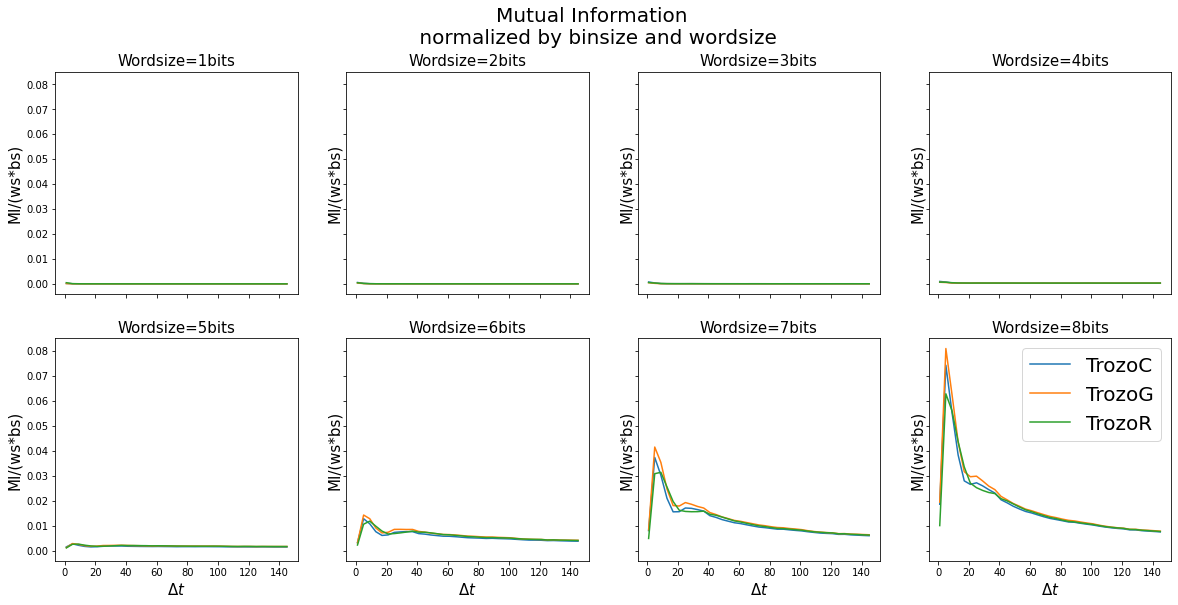

In [ ]:
plot_MI_comparative(main_metrics_SAX)

## **8. References**



[1] Shannon, C. E., & Weaver, W. (1949). The mathematical theory of communication. University of Illinois Press.

[2] Rodríguez Ortiz, Francisco de Borja & Latorre, Roberto & Varona, Pablo. (2002). Characterization of Triphasic Rhythms in Central Pattern Generators (II): Burst Information Analysis. Lect. Notes Comput. Sci. 2415. 796-796. 10.1007/3-540-46084-5_28. 

[3] Lin, Jessica & Keogh, Eamonn & Wei, Li & Lonardi, Stefano. (2007). Experiencing SAX: A Novel Symbolic Representation of Time Series. Data Min. Knowl. Discov.. 15. 107-144. 10.1007/s10618-007-0064-z. 